In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
import seaborn as sns
from scipy.ndimage import convolve1d
import psycopg2
import datetime
import time 

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

/Users/eventura/anaconda/envs/ppg/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
try:
    conn = psycopg2.connect(dbname='amiigo_platform_sherpa',
                            user='savvy_read',
                            host='10.1.0.141',
                            password='savvy_read',
                            port = '15610')
except:
    print("failed to connect")

In [3]:
from db import DB

amiigo_db = DB(dbname='amiigo_platform_sherpa',
                username='savvy_read',
                hostname='10.1.0.141',
                password='savvy_read',
                port = '15610', 
                dbtype = "postgres")

In [4]:
# Contents of the amiigo database

amiigo_db.tables

Refreshing schema. Please wait...done!


+------------------------------------------------+----------------------------------------------------------------------------------+
| Table                                          | Columns                                                                          |
+------------------------------------------------+----------------------------------------------------------------------------------+
| activities_goal                                | id, date, user_id, type, target, value                                           |
| activities_metric                              | id, order, date, user_id, type, low, low_datetime, median, median_datetime, high |
|                                                | , high_datetime, pstatus                                                         |
| auth_group                                     | name, id                                                                         |
| auth_group_permissions                         | group_id, permission_id, id                                                      |
| auth_permission                                | name, content_type_id, codename, id                                              |
| authtoken_token                                | key, user_id, created                                                            |
| celery_taskmeta                                | task_id, status, result, date_done, traceback, hidden, meta, id                  |
| celery_tasksetmeta                             | taskset_id, result, date_done, hidden, id                                        |
| core_amiigouser                                | password, last_login, is_superuser, username, first_name, last_name, email, is_s |
|                                                | taff, is_active, date_joined, is_developer, is_in_studygroup, height, weight, bi |
|                                                | rthdate, sex, wristband_laterality, shoepod_laterality, provisioning_key_id, uni |
|                                                | t_of_measurement, location, image, gravatar_url, is_validated, validation_key, e |
|                                                | ye_color, hair_color, walk_stride, run_stride, resting_hr_awake, resting_hr_slee |
|                                                | ping, minimum_hr, hr_variability, pulse_oxygen, respiratory_rate_lower, respirat |
|                                                | ory_rate_upper, arterial_pressure, sys_period, dia_period, avg_daily_steps, avg_ |
|                                                | daily_sleep, does_routine_workouts, muscle_targets, user_class, avg_calories_bur |
|                                                | ned, avg_inactivity_time, avg_activity_time, avg_cardio_time, avg_resistance_tim |
|                                                | e, pstatus, id                                                                   |
| core_amiigouser_groups                         | amiigouser_id, group_id, id                                                      |
| core_amiigouser_managed_users                  | from_amiigouser_id, to_amiigouser_id, id                                         |
| core_amiigouser_user_permissions               | amiigouser_id, permission_id, id                                                 |
| core_bugreport                                 | created_at, modified_at, id, user_id, app_instance_id, problem, resolution, note |
|                                                | s, issue_url                                                                     |
| core_bugreportlogfile                          | created_at, modified_at, id, bugreport_id, logfile                               |
| core_bugreportscreenshot                       | created_at, modified_at, id, bugreport_id, screenshot                            |
| core_message                                   | created_at, modified_at, id, user_id, app_instance_id, destinat

### Extract Sleep Data from Amiigo Database

In [5]:
res = amiigo_db.query("select user_id, count(user_id) from sleep_sleepdata group by user_id order by count(user_id) DESC")
res

user_id  count
0       21     29
1       15     28
2       14     11
3       22      9
4       23      6
5       19      5
6       18      5
7       17      3
8       16      1

In [6]:
%%time
sleep_data  = amiigo_db.query("Select * from sleep_sleepdata")

CPU times: user 7.98 s, sys: 6.14 s, total: 14.1 s
Wall time: 9min 43s


In [7]:
users = amiigo_db.query("select * from core_amiigouser order by id")
users

id                                           password  \
0    1                                                      
1    2  pbkdf2_sha256$12000$EDbvHkvhPk0J$H4xgEfCrUfd0R...   
2    3  pbkdf2_sha256$12000$f7eJ4Ordo9XD$rUL4IjquB30B2...   
3    5  pbkdf2_sha256$12000$URN87l2gDUCm$gniw0fxXxt6ff...   
4    7  pbkdf2_sha256$12000$wMi82f30a2FT$lUQve9C8BX2oh...   
5    8  pbkdf2_sha256$12000$AVTyAroe9ERO$5qFHiB9hEZIHO...   
6    9  pbkdf2_sha256$12000$Ty9PRpU99YTC$d/EKWHXeokAZW...   
7   10  pbkdf2_sha256$12000$9o5bphYS5p1c$A/kgR0qQ7qdFY...   
8   11  pbkdf2_sha256$12000$VkvIPB3owIR6$zEOeJRqyWQqN4...   
9   12  pbkdf2_sha256$12000$gdyKS6k8sOhE$JwrFYzpinvMsK...   
10  13  pbkdf2_sha256$12000$w1ISgKJVqqCv$98lWBQMmGdwDn...   
11  14  pbkdf2_sha256$12000$yYDQ1Hw1llPw$UFnzv6kEuVeWj...   
12  15  pbkdf2_sha256$12000$VfEJtw2Nzyx6$kErvnpTuAEqct...   
13  16  pbkdf2_sha256$12000$LtIlyPyP4rSE$vsfQ63LLtCHzm...   
14  17  pbkdf2_sha256$12000$iWiUT8CBsKBK$lOX3fyD3fVYF5...   
15  18  pbkdf2_sha256$12000$RzWtBef2S2tQ$hHTyqaHAHDgR5...   
16  19  pbkdf2_sha256$12000$Q4QBVZRFPEXX$8VXk8JAzTS3Lf...   
17  20  pbkdf2_sha256$12000$GScm4JzT1d3s$TwDAeIVeJ1mFD...   
18  21  pbkdf2_sha256$12000$gk0t3xuboz1U$yiv4XdTkcam2a...   
19  22  pbkdf2_sha256$12000$W6Xcqoz01SOz$L1W2XMikENX3S...   
20  23  pbkdf2_sha256$12000$5TGmkTMwzb5y$AA+jihANpuIZz...   
21  24  pbkdf2_sha256$12000$7egrZgtDHAow$l04Y5EqUBTAsv...   
22  25  pbkdf2_sha256$12000$d5Glpq1jCQtW$SrSobsvfev+Uk...   
23  26  pbkdf2_sha256$12000$9PChy5cq4Hr3$Jnudi6kOuq0Zg...   
24  27  pbkdf2_sha256$12000$TCLPEqOFqJZw$HyvNuHz2ZNy2n...   

                         last_login is_superuser      username    first_name  \
0  2013-08-07 22:45:22.278000+00:00         True         admin        Amiigo   
1  2016-06-30 22:45:45.496417+00:00         True          luke                 
2  2016-11-29 15:15:45.498321+00:00         True   savvy_admin                 
3  2016-07-01 18:24:48.045390+00:00        False      rosbsnjc     Rohintest   
4  2016-07-01 22:09:55.264517+00:00        False      xxxzbzbx        Dhbxbx   
5  2016-07-01 22:14:17.621770+00:00        False         sbsbd             D   
6  2016-07-01 22:14:58.929999+00:00        False        sdjxjx          Snjx   
7  2016-07-01 22:18:22.986061+00:00        False             d         Dave    
8  2016-07-01 22:21:14.543200+00:00        False           jjd         Djdjv   
9  2016-07-01 22:21:39.578123+00:00        False            jn            Bb   
10 2016-07-01 22:22:12.231234+00:00        False            hb            Hh   
11 2016-11-16 01:38:03.977464+00:00         True      mengtint          Meng   
12 2016-11-16 01:42:09.442474+00:00         True   ekipmanager        Keivan   
13        2016-07-06 22:50:10+00:00        False        foobar           Foo   
14        2016-07-10 21:49:20+00:00         True     bearnshaw        Berton   
15 2016-11-14 05:48:58.562182+00:00         True        jroxas       Josepht   
16 2016-11-15 16:10:41.725356+00:00         True     bninopaul     Nino Paul   
17 2016-07-11 19:09:12.451198+00:00        False        taimik         Taimi   
18 2016-09-02 01:13:52.369640+00:00         True           jed           Jed   
19 2016-08-24 13:02:21.154614+00:00         True     meventura  Maria Eloisa   
20 2016-09-13 21:20:39.709975+00:00        False         ldvle          Viet   
21 2016-09-13 21:27:29.865922+00:00        False  kirkknowlton          Kirk   
22        2016-11-14 06:36:45+00:00         True       xpuspus        Xavier   
23        2016-11-15 15:04:31+00:00         True       jjungao    John Titus   
24 2016-11-29 23:09:21.671194+00:00        False      gromrell          Greg   

    last_name                            email is_staff is_active  \
0       Admin                 admin@amiigo.com     True      True   
1                          lgraybill@izeni.com     True      True   
2                                                  True      True   
3         Bbb                  rohin@gmail.com    False     

In [8]:
## Select sleep data of a user

user = 'meventura'
userid = users.loc[users['username'] == user].id.values

sleep_data_user = (sleep_data.loc[sleep_data['user_id'] == userid[0]]).reset_index()


In [9]:
sleep_data_user

index                       created_at                      modified_at  \
0     35 2016-12-01 07:11:54.646233+00:00 2016-12-01 07:12:49.453064+00:00   
1     76 2016-11-30 15:33:59.252596+00:00 2016-11-30 15:34:00.137813+00:00   
2     83 2016-11-30 05:53:26.174197+00:00 2016-11-30 05:53:27.166165+00:00   
3     85 2016-12-01 09:36:11.638198+00:00 2016-12-01 09:36:48.377265+00:00   
4     88 2016-11-30 14:32:41.625196+00:00 2016-11-30 14:32:42.600312+00:00   
5     89 2016-11-30 15:45:45.267831+00:00 2016-11-30 15:45:46.294297+00:00   
6     94 2016-11-30 14:04:35.609738+00:00 2016-11-30 14:04:36.472296+00:00   
7     95 2016-12-01 12:02:08.560945+00:00 2016-12-01 12:02:26.621432+00:00   
8     96 2016-12-01 12:02:29.847682+00:00 2016-12-01 12:03:02.517339+00:00   

                                 id                       started_at  \
0  5ad11c430bc44810b51b0ee5f5cfb26c 2016-11-30 16:58:01.774000+00:00   
1  bcff324b679f4fe29afbaa66a992ef17 2016-11-30 14:55:50.608000+00:00   
2  e711e901f27e4091adafaab174df7923 2016-11-30 04:41:14.474000+00:00   
3  5f97b8ee51514b8ebd1fbf467c030956 2016-12-01 08:30:26.471000+00:00   
4  b17e02e781864677a190225a40b067ac 2016-11-30 14:05:10.294000+00:00   
5  f868cb55435a41ecae07aea47922d58c 2016-11-30 15:09:08.080000+00:00   
6  4c91ac4f78a3492798bb1da8ddb6a41c 2016-11-30 13:56:55.462000+00:00   
7  ef90c835801d47d3aaf2d3984acb7590 2016-12-01 11:26:00.542000+00:00   
8  cac14dd1834f4ed19df4dc4bec005666 2016-12-01 10:32:02.978000+00:00   

                          ended_at calendar_date data_integrity  \
0 2016-12-01 07:07:51.581000+00:00    2016-12-01           None   
1 2016-11-30 15:04:16.860000+00:00    2016-11-30           None   
2 2016-11-30 05:53:06.620000+00:00    2016-11-30           None   
3 2016-12-01 09:27:54.646000+00:00    2016-12-01           None   
4 2016-11-30 14:30:09.468000+00:00    2016-11-30           None   
5 2016-11-30 15:45:09.584000+00:00    2016-11-30           None   
6 2016-11-30 14:04:32.464000+00:00    2016-11-30           None   
7 2016-12-01 11:42:34.004000+00:00    2016-12-01           None   
8 2016-12-01 11:11:24.599000+00:00    2016-12-01           None   

  data_integrity_reason                                      sample_counts  \
0                  None  gAJ9cQEoWAUAAAB0b3RhbHECSt41AQBYDAAAADFDQkE4Qz...   
1                  None  gAJ9cQEoWAUAAAB0b3RhbHECTVACWAwAAAAxQ0JBOEMyRk...   
2                  None  gAJ9cQEoWAUAAAB0b3RhbHECTQITWAwAAAAxQ0JBOEMyRk...   
3                  None  gAJ9cQEoWAUAAAB0b3RhbHECTf7QWAwAAAAxQ0JBOEMyRk...   
4                  None  gAJ9cQEoWAUAAAB0b3RhbHECTcIGWAwAAAAxQ0JBOEMyRk...   
5                  None  gAJ9cQEoWAUAAAB0b3RhbHECTbQJWAwAAAAxQ0JBOEMyRk...   
6                  None  gAJ9cQEoWAUAAAB0b3RhbHECTRcCWAwAAAAxQ0JBOEMyRk...   
7                  None  gAJ9cQEoWAUAAAB0b3RhbHECTatLWAwAAAAxQ0JBOEMyRk...   
8                  None  gAJ9cQEoWAUAAAB0b3RhbHECTR6vWAwAAAAxQ0JBOEMyRk...   

   average_wristband_temp average_shoepod_temp  calories_overall  duration  \
0                  105.08                 None                 0     50989   
1                   90.50                 None                 0       506   
2                   90.14                 None                 0      4312   
3                   98.60                 None                 0      3448   
4                   91.40                 None                 0      1499   
5                   91.40                 None                 0      2161   
6                   93.38                 None                 0       457   
7                   94.82                 None                 0       993   
8                   98.78                 None                 0      2361   

   session_duration  bpm bpm_detail    status  reboots good_wristband_z_axis  \
0             50990  0.0       None  finished        1                  True   
1                 0  NaN       None  finished        0                  True   
2                 0  NaN    

In [10]:
sleep_data_captures = sleep_data_user.captures
sleep_data_captures

0    {'deg.sp': {'1480528113774': None, '1480525276...
1                                                 None
2                                                 None
3    {'deg.sp': {'1480584197471': None, '1480581351...
4                                                 None
5                                                 None
6                                                 None
7    {'_loc': {'1480592511542': 'l', '1480591707542...
8    {'deg.sp': {'1480589243978': None, '1480590152...
Name: captures, dtype: object

In [11]:
sampling_rate = 30 # Hertz

Capture intervals (sec) :  [   0.   51.   51.   52.   51.   41.   51.   51.   41.   51.   41.   52.
   40.   52.   51.   41.   51.   92.   51.   41.   52.   41.   51.   41.
  102.   41.   92.   51.   41.  123.  185.   51.   51.   41.   51.   41.
   51.   41.   51.   52.   41.   51.   41.   51.   51.   51.   52.   51.
   51.   41.   61.   52.   41.  102.   41.   61.   52.   48.   52.   41.
   51.   51.   41.   51.   41.   51.   41.   52.   51.   41.   51.   41.]


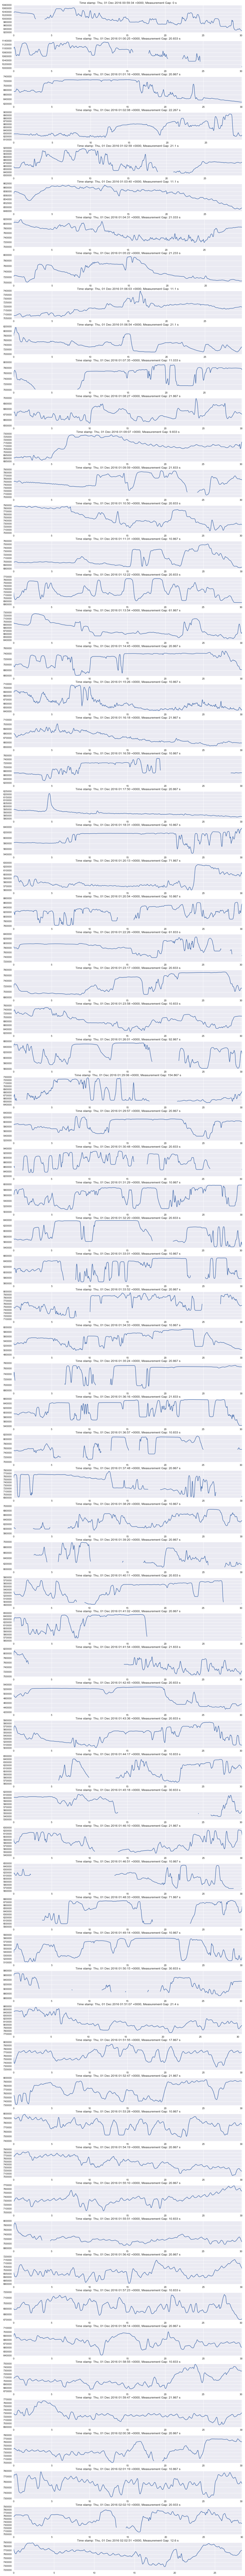

In [12]:
sleep_index = 0 

ppg_time_stamp_captures = sleep_data_captures.ix[sleep_index]['_vec.ir'].keys()
millisec = np.sort(np.array(list(ppg_time_stamp_captures), dtype = float))

# timestamps
captures_index = np.array(np.array(millisec, dtype = int), dtype=str)

# Calculate time interval between time stamps
capture_interval = millisec[1:] - millisec[:-1]
capture_interval = np.insert(capture_interval, 0, values = 0,  axis = 0)/1000

print('Capture intervals (sec) : ', capture_interval)
# print('')

# Visualize captures
f, axarr = plt.subplots(len(captures_index), 1)
f.set_figheight(2.5*len(captures_index))
f.set_figwidth(16)
f.subplots_adjust(hspace = 0.3)

for i in np.arange(len(captures_index)):
    ppg_ir = (sleep_data_captures.ix[sleep_index]['_vec.ir'])[captures_index[i]]
    time_ir = np.arange(len(ppg_ir))/sampling_rate
    
    # Get duration of time without recorded measuremement, i.e. time from last data point from
    # previous capture to the time of first data point in current capture
    if i > 0:
        measurement_gap = (capture_interval[i] - (len(ppg_ir))/sampling_rate)
    else: 
        measurement_gap = 0
        
    measurement_gap = str(round(measurement_gap, 3))
    axarr[i].plot(time_ir, ppg_ir)
    axarr[i].set_xlim(0, time_ir[-1])
    axarr[i].set_title('Time stamp: ' + time.strftime("%a, %d %b %Y %H:%M:%S +0000", 
                                             time.localtime(float(captures_index[i])/1000)) + ', Measurement Gap: ' + measurement_gap +' s')


### *Observations:*

* For the sleep data set above, the **captures** column contains all the recordings of the amiigo device during the sleep duration. 

    * The **captures** column has the following keys: 
    
    
    ['c.lvet', 'ppv.pc', 'c.rtt.orig', 'P', '_fs', 'deg.spn', '_diag.low.afib.is', '_vec.accel', 'i.m', '_label', 'amp.pp.pp', 'hrv.std', '_diag.thunder.is', 'i.lvef', 'c.qt.err', '_fs.accel', 'c.rtt.err', 'hrv.rms', 'hrv.rms.low.err', 'deg.sru', '_age', '_diag.ranon.is', 'brpm', 'c.qtc.err', 'hrv.std.err', '_vec.invalids', '_loc', '_is_manual', 'brpm.err', 'pp.volv', 'pp.sp/dp', 'bpm.cnt', 'deg.drd', '_is_vein', 'c.co', 'hrv.rms.err', 'b/a', '_diag.apnea.is', 'beats.valid', 'red.offset', 'c.qtc', 'spo2.err', 'pp.stvol', 'pp.vol.err', 'c.qrs', 'c.rtt', 'd/a', 'i.ef', 'pp.vol', '_vec.span', '_vec.clusters', '_sex', '_vec.ir', 'deg.sp', 'bpm', '_seq', '_in.start_accel', 'i.sru', 'delta', 'hrv.rms.low', 'ir.offset', '_diag.afib.is', 'brdb', '_vec.red', '_pk', 'c.qrs.err', 'ppv.pc.err', 'pp.nsp/ndp', 'pp.aug', 'hrv.pc', '_height', 'c.qt', 'spo2', 'stemp', 'bpm.ccnt', 'c.lvet.err', 'bpm.rng', 'pp.nsp/ref']
    
* Each key above corresponds to another dictionary whose keys are the timestamps of the ppg captures collected.
    * The actual ppg signals are in **_vec.ir** for the IR channel and **_vec.red** for the red channel.
    
    
* The infrared ppg signals found are all 30-second long. 


* The measurement gaps (duration with no measurement) between captures are not consistent. 


* The sleep HR interval set in the Amiigo app was 45 seconds. 

*Note: The sleep HR interval is interval between the start of each collection. I think, the device collects data for 30 seconds, and 15 seconds later (if the HR interval is 45 seconds), the device collects again. The minimum HR interval allowed by the app is 41 seconds, which would mean that there is measurement gap of approximately 11 seconds between every capture.  *


    

Capture intervals (sec) :  [   0.   48.   88.   39.   51.   38.   49.   49.   88.   39.   48.   60.
  137.   88.   49.   88.   39.   49.   88.   88.   88.   48.   40.   49.
   89.   87.   49.  137.   39.   50.   40.  135.   98.  138.   88.   48.
   39.   88.   50.   49.   39.   49.   39.   48.   49.   39.   49.   40.
   48.   40.   49.   49.   39.   48.]


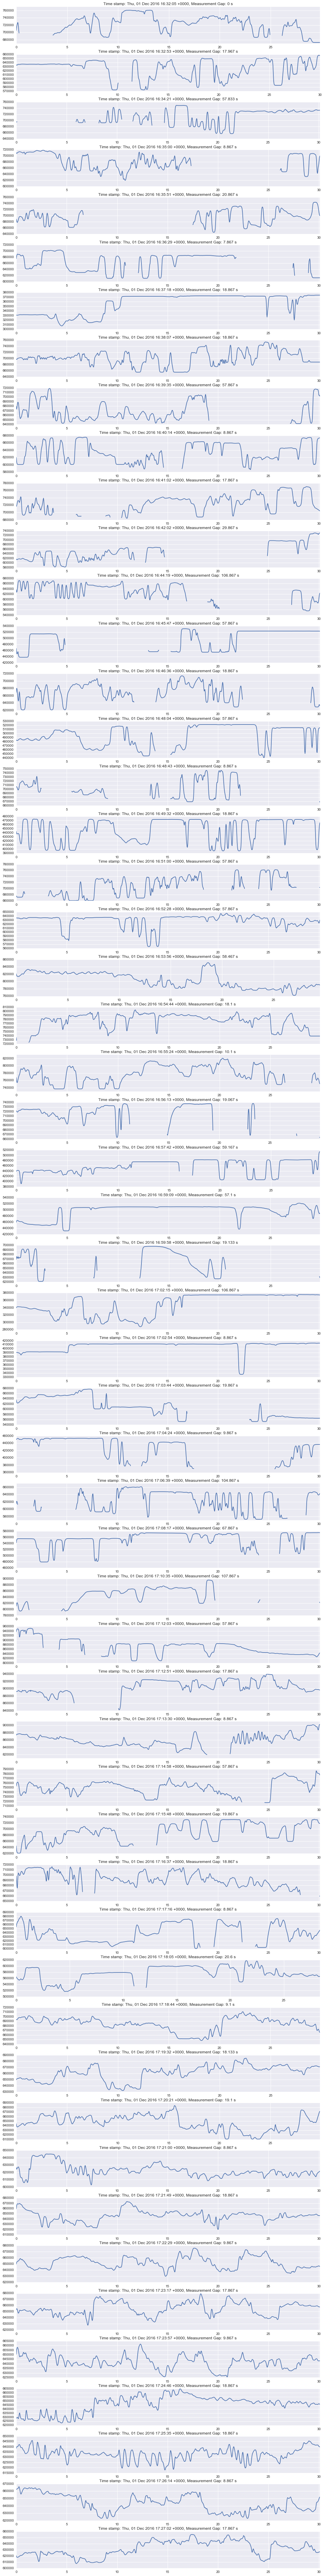

In [13]:
sleep_index = 3

ppg_time_stamp_captures = sleep_data_captures.ix[sleep_index]['_vec.ir'].keys()
millisec = np.sort(np.array(list(ppg_time_stamp_captures), dtype = float))

# timestamps
captures_index = np.array(np.array(millisec, dtype = int), dtype=str)

# Calculate time interval between time stamps
capture_interval = millisec[1:] - millisec[:-1]
capture_interval = np.insert(capture_interval, 0, values = 0,  axis = 0)/1000

print('Capture intervals (sec) : ', capture_interval)
# print('')

# Visualize captures
f, axarr = plt.subplots(len(captures_index), 1)
f.set_figheight(2.5*len(captures_index))
f.set_figwidth(16)
f.subplots_adjust(hspace = 0.3)

for i in np.arange(len(captures_index)):
    ppg_ir = (sleep_data_captures.ix[sleep_index]['_vec.ir'])[captures_index[i]]
    time_ir = np.arange(len(ppg_ir))/sampling_rate
    
    # Get duration of time without recorded measuremement, i.e. time from last data point from
    # previous capture to the time of first data point in current capture
    if i > 0:
        measurement_gap = (capture_interval[i] - (len(ppg_ir))/sampling_rate)
    else: 
        measurement_gap = 0
        
    measurement_gap = str(round(measurement_gap, 3))
    axarr[i].plot(time_ir, ppg_ir)
    axarr[i].set_xlim(0, time_ir[-1])
    axarr[i].set_title('Time stamp: ' + time.strftime("%a, %d %b %Y %H:%M:%S +0000", 
                                             time.localtime(float(captures_index[i])/1000)) + ', Measurement Gap: ' + measurement_gap +' s')


Capture intervals (sec) :  [  0.  51.  48.  39.  49.  39.  51.  37.  50.  49.  40.  48.  39.  48.  49.
  40.  49.  88.  40.  49.]


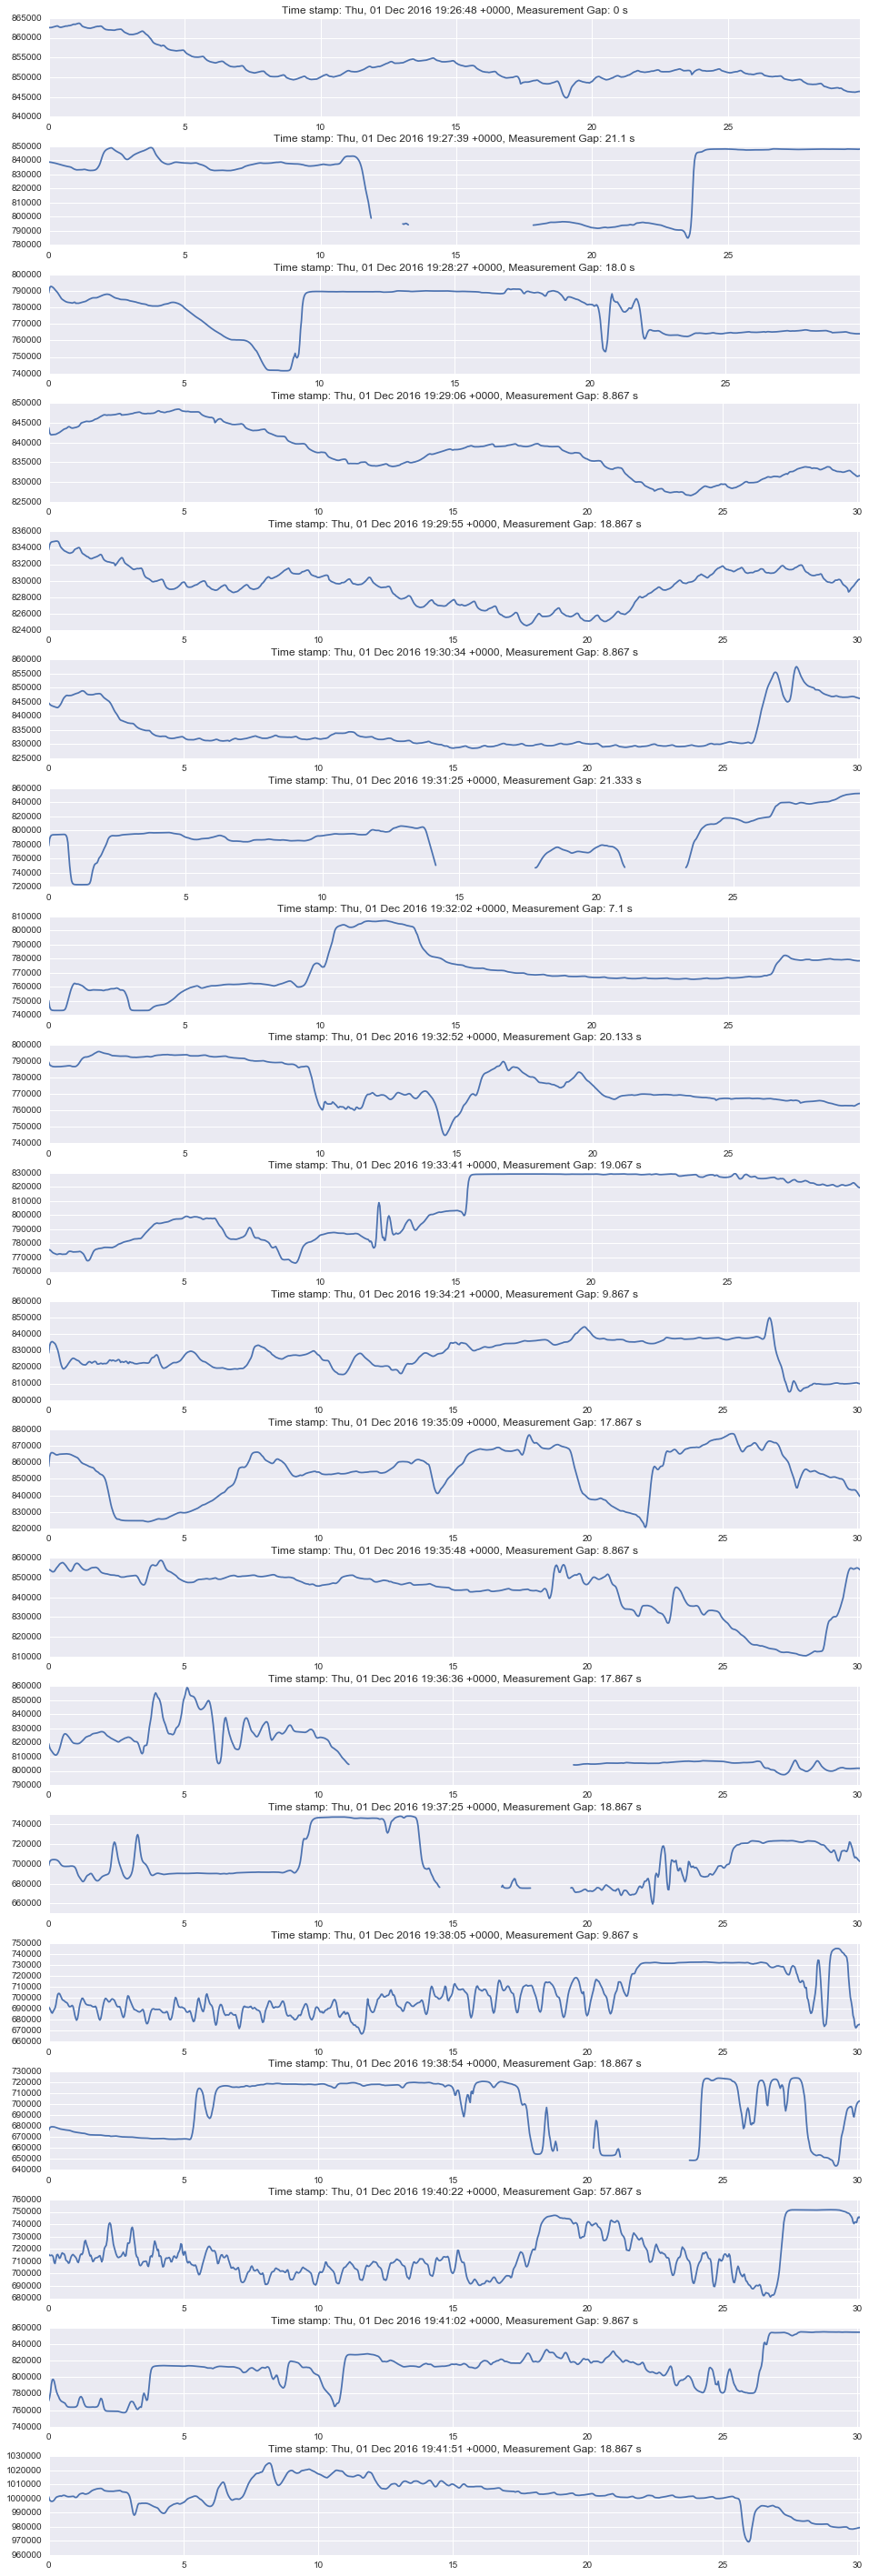

In [14]:
sleep_index = 7 

ppg_time_stamp_captures = sleep_data_captures.ix[sleep_index]['_vec.ir'].keys()
millisec = np.sort(np.array(list(ppg_time_stamp_captures), dtype = float))

# timestamps
captures_index = np.array(np.array(millisec, dtype = int), dtype=str)

# Calculate time interval between time stamps
capture_interval = millisec[1:] - millisec[:-1]
capture_interval = np.insert(capture_interval, 0, values = 0,  axis = 0)/1000

print('Capture intervals (sec) : ', capture_interval)
# print('')

# Visualize captures
f, axarr = plt.subplots(len(captures_index), 1)
f.set_figheight(2.5*len(captures_index))
f.set_figwidth(16)
f.subplots_adjust(hspace = 0.3)

for i in np.arange(len(captures_index)):
    ppg_ir = (sleep_data_captures.ix[sleep_index]['_vec.ir'])[captures_index[i]]
    time_ir = np.arange(len(ppg_ir))/sampling_rate
    
    # Get duration of time without recorded measuremement, i.e. time from last data point from
    # previous capture to the time of first data point in current capture
    if i > 0:
        measurement_gap = (capture_interval[i] - (len(ppg_ir))/sampling_rate)
    else: 
        measurement_gap = 0
        
    measurement_gap = str(round(measurement_gap, 3))
    axarr[i].plot(time_ir, ppg_ir)
    axarr[i].set_xlim(0, time_ir[-1])
    axarr[i].set_title('Time stamp: ' + time.strftime("%a, %d %b %Y %H:%M:%S +0000", 
                                             time.localtime(float(captures_index[i])/1000)) + ', Measurement Gap: ' + measurement_gap +' s')


Capture intervals (sec) :  [   0.   61.  137.   38.   49.   49.   39.   50.   38.   50.   39.   49.
   48.   39.   49.   40.   49.   49.   39.   49.   39.   49.   48.   49.
   49.   39.   51.   87.   48.   89.   48.   40.   88.   58.   39.   49.
   40.   49.   39.   49.   49.   40.   48.   39.   49.   39.]


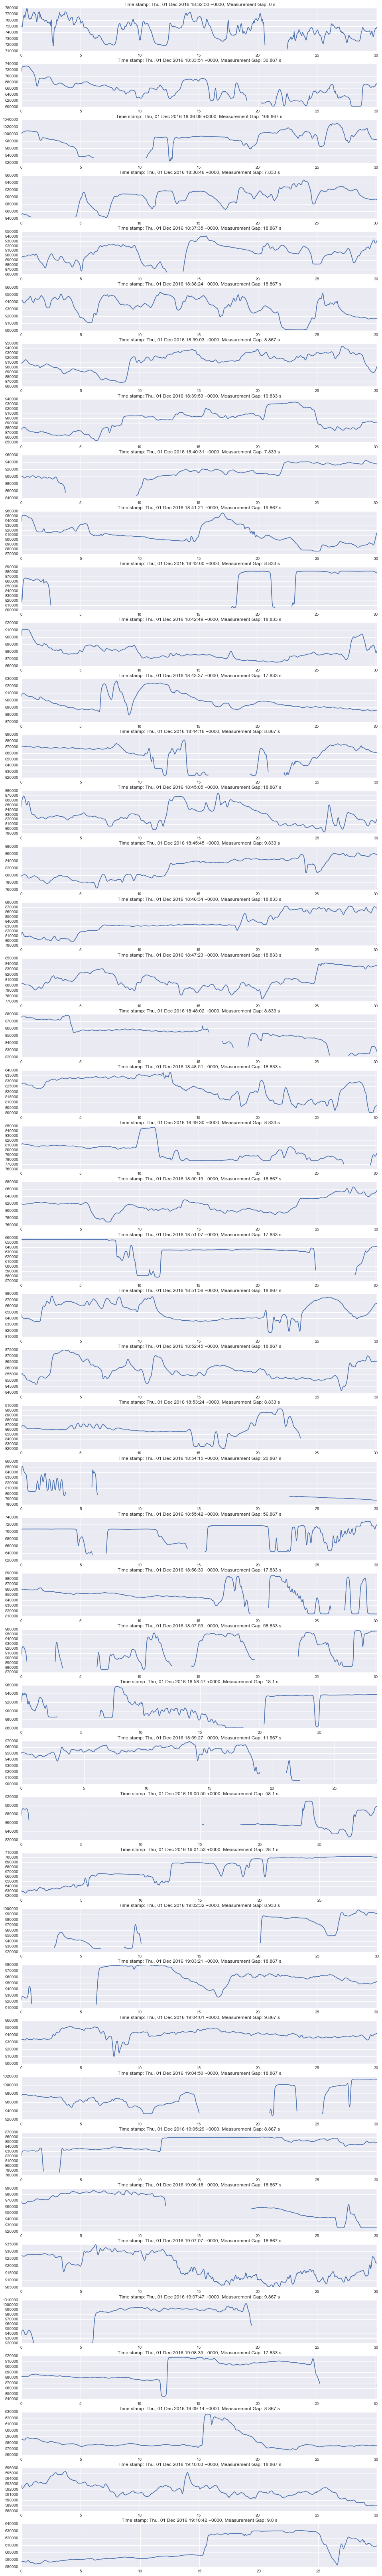

In [15]:
sleep_index = 8 

ppg_time_stamp_captures = sleep_data_captures.ix[sleep_index]['_vec.ir'].keys()
millisec = np.sort(np.array(list(ppg_time_stamp_captures), dtype = float))

# timestamps
captures_index = np.array(np.array(millisec, dtype = int), dtype=str)

# Calculate time interval between time stamps
capture_interval = millisec[1:] - millisec[:-1]
capture_interval = np.insert(capture_interval, 0, values = 0,  axis = 0)/1000

print('Capture intervals (sec) : ', capture_interval)
# print('')

# Visualize captures
f, axarr = plt.subplots(len(captures_index), 1)
f.set_figheight(2.5*len(captures_index))
f.set_figwidth(16)
f.subplots_adjust(hspace = 0.3)

for i in np.arange(len(captures_index)):
    ppg_ir = (sleep_data_captures.ix[sleep_index]['_vec.ir'])[captures_index[i]]
    time_ir = np.arange(len(ppg_ir))/sampling_rate
    
    # Get duration of time without recorded measuremement, i.e. time from last data point from
    # previous capture to the time of first data point in current capture
    if i > 0:
        measurement_gap = (capture_interval[i] - (len(ppg_ir))/sampling_rate)
    else: 
        measurement_gap = 0
        
    measurement_gap = str(round(measurement_gap, 3))
    axarr[i].plot(time_ir, ppg_ir)
    axarr[i].set_xlim(0, time_ir[-1])
    axarr[i].set_title('Time stamp: ' + time.strftime("%a, %d %b %Y %H:%M:%S +0000", 
                                             time.localtime(float(captures_index[i])/1000)) + ', Measurement Gap: ' + measurement_gap +' s')
